## Run INSPIRE on the whole-embryo datasets generated by seqFISH and Stereo-seq

In this tutorial, we show INSPIRE's capability of integrating and interpreting ST whole-embryo datasets across different technologies (seqFISH and Stereo-seq). The cross-technology integration enables multiple downstream analysis to facilitate deep biological insights.

### Import packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import umap
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D

import INSPIRE

import warnings
warnings.filterwarnings("ignore")

### Load data

In [2]:
print("Load seqFISH data...")

data_dir = "data/seqFISH_mouse_embryo"
counts = pd.read_csv(data_dir+"/counts.csv", index_col=0)
metadata = pd.read_csv(data_dir+"/metadata.csv", index_col=0)
metadata = metadata.loc[counts.index, :]
adata_seqfish = ad.AnnData(np.array(counts.values))
adata_seqfish.var.index = counts.columns
adata_seqfish.obs = metadata

adata_seqfish = adata_seqfish[adata_seqfish.obs["embryo"] == "embryo2", ]
adata_seqfish = adata_seqfish[adata_seqfish.obs["celltype_mapped_refined"] != "Low quality", ]
adata_seqfish.obsm["spatial"] = np.array(adata_seqfish.obs[["x_global", "y_global"]])
adata_seqfish.var_names_make_unique()

Load seqFISH data...


In [3]:
print("Load Stereo-seq data...")

data_dir = "data/Stereoseq_mouse_embryo"
adata_stereoseq = sc.read_h5ad(os.path.join(data_dir, "E9.5_E1S1.MOSTA.h5ad"))
adata_stereoseq.X = adata_stereoseq.layers['count']
adata_stereoseq.var_names_make_unique()

Load Stereo-seq data...


In [4]:
adata_st_list = [adata_seqfish, adata_stereoseq]

### Data preprocessing

Get shared genes among all datasets...
Find 347 shared genes among datasets.
Finding highly variable genes...
shape of adata 0 before quality control:  (14185, 347)
shape of adata 0 after quality control:  (14185, 347)
shape of adata 1 before quality control:  (5913, 347)
shape of adata 1 after quality control:  (5880, 344)
Find 344 shared highly variable genes among datasets.
Concatenate datasets as a full anndata for better visualization...


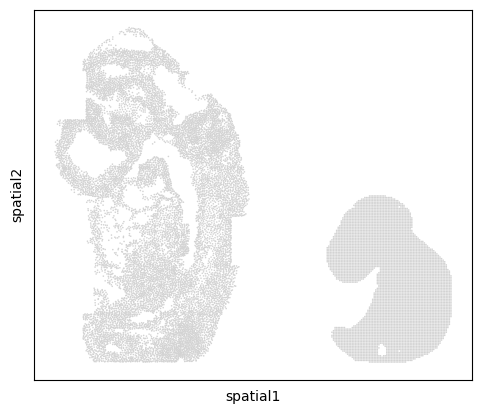

Store counts and library sizes for Poisson modeling...
Normalize data...


In [5]:
adata_st_list, adata_full = INSPIRE.utils.preprocess(adata_st_list=adata_st_list,
                                                     num_hvgs=1000,
                                                     min_genes_qc=2,
                                                     min_cells_qc=2,
                                                     spot_size=1,
                                                     limit_num_genes=True)

### Build spatial graph and prepare node features for LGCN

In [6]:
adata_st_list = INSPIRE.utils.build_graph_LGCN(adata_st_list=adata_st_list, 
                                               rad_cutoff_list=[3,1.6])

Start building graphs...
Build graphs and prepare node features for LGCN networks
Radius for graph connection is 3.0000.
26.7748 neighbors per cell on average.
Node features for slice 0 : (14185, 688)
Radius for graph connection is 1.6000.
7.7946 neighbors per cell on average.
Node features for slice 1 : (5880, 688)


### Run INSPIRE model

In [8]:
model = INSPIRE.model.Model_LGCN(adata_st_list=adata_st_list,
                                 n_spatial_factors=40,
                                 n_training_steps=10000,
                                 batch_size=2048,
                                 different_platforms=True
                                 )

In [9]:
model.train(adata_st_list)

  0%|          | 6/10000 [00:00<07:48, 21.34it/s]

Step: 0, d_loss: 1.4992, Loss: 1364.8623, recon_loss: 552.5065, fe_loss: 44.9286, geom_loss: 165.7725, beta_loss: 763.3344, gan_loss: 0.7776


  5%|▌         | 506/10000 [00:11<03:29, 45.35it/s]

Step: 500, d_loss: 0.6237, Loss: 1167.3342, recon_loss: 433.0272, fe_loss: 28.1169, geom_loss: 87.4508, beta_loss: 702.1931, gan_loss: 2.2480


 10%|█         | 1006/10000 [00:22<03:16, 45.76it/s]

Step: 1000, d_loss: 0.3045, Loss: 1076.6626, recon_loss: 341.4729, fe_loss: 27.3702, geom_loss: 130.6975, beta_loss: 701.8184, gan_loss: 3.3872


 15%|█▌        | 1506/10000 [00:33<03:07, 45.34it/s]

Step: 1500, d_loss: 0.2098, Loss: 1014.6364, recon_loss: 279.4295, fe_loss: 26.9022, geom_loss: 131.7953, beta_loss: 701.8845, gan_loss: 3.7844


 20%|██        | 2006/10000 [00:44<02:56, 45.35it/s]

Step: 2000, d_loss: 0.2105, Loss: 973.4398, recon_loss: 237.6814, fe_loss: 26.6580, geom_loss: 124.8234, beta_loss: 702.2662, gan_loss: 4.3377


 25%|██▌       | 2506/10000 [00:55<02:43, 45.73it/s]

Step: 2500, d_loss: 0.2238, Loss: 949.7872, recon_loss: 214.8734, fe_loss: 26.5242, geom_loss: 119.8150, beta_loss: 702.2215, gan_loss: 3.7718


 30%|███       | 3006/10000 [01:06<02:33, 45.69it/s]

Step: 3000, d_loss: 0.1744, Loss: 928.3311, recon_loss: 194.4388, fe_loss: 26.3288, geom_loss: 109.8261, beta_loss: 701.8584, gan_loss: 3.5087


 35%|███▌      | 3506/10000 [01:17<02:22, 45.62it/s]

Step: 3500, d_loss: 0.1483, Loss: 922.0637, recon_loss: 187.6211, fe_loss: 26.2629, geom_loss: 105.1442, beta_loss: 701.8630, gan_loss: 4.2138


 40%|████      | 4006/10000 [01:28<02:12, 45.36it/s]

Step: 4000, d_loss: 0.2480, Loss: 909.9057, recon_loss: 176.3834, fe_loss: 26.1227, geom_loss: 100.0805, beta_loss: 701.8671, gan_loss: 3.5309


 45%|████▌     | 4506/10000 [01:39<02:00, 45.52it/s]

Step: 4500, d_loss: 0.2300, Loss: 910.6376, recon_loss: 177.2427, fe_loss: 26.1271, geom_loss: 98.9051, beta_loss: 701.7460, gan_loss: 3.5437


 50%|█████     | 5006/10000 [01:50<01:50, 45.24it/s]

Step: 5000, d_loss: 0.3022, Loss: 901.6885, recon_loss: 167.7816, fe_loss: 26.0828, geom_loss: 99.3437, beta_loss: 701.8264, gan_loss: 4.0109


 55%|█████▌    | 5506/10000 [02:01<01:39, 45.32it/s]

Step: 5500, d_loss: 0.2461, Loss: 903.7646, recon_loss: 170.3498, fe_loss: 26.1392, geom_loss: 91.4499, beta_loss: 701.7339, gan_loss: 3.7127


 60%|██████    | 6006/10000 [02:12<01:27, 45.77it/s]

Step: 6000, d_loss: 0.2192, Loss: 896.4146, recon_loss: 163.2331, fe_loss: 26.1898, geom_loss: 88.4344, beta_loss: 701.5472, gan_loss: 3.6757


 65%|██████▌   | 6506/10000 [02:23<01:16, 45.75it/s]

Step: 6500, d_loss: 0.2820, Loss: 899.3956, recon_loss: 166.6798, fe_loss: 26.2029, geom_loss: 80.5115, beta_loss: 701.5717, gan_loss: 3.3311


 70%|███████   | 7006/10000 [02:34<01:05, 45.50it/s]

Step: 7000, d_loss: 0.2347, Loss: 890.3608, recon_loss: 158.0955, fe_loss: 26.1279, geom_loss: 76.1080, beta_loss: 701.5854, gan_loss: 3.0298


 75%|███████▌  | 7506/10000 [02:45<00:54, 45.69it/s]

Step: 7500, d_loss: 0.2511, Loss: 889.9950, recon_loss: 157.2804, fe_loss: 26.1080, geom_loss: 72.4438, beta_loss: 701.7313, gan_loss: 3.4264


 80%|████████  | 8006/10000 [02:55<00:44, 45.29it/s]

Step: 8000, d_loss: 0.2183, Loss: 889.2778, recon_loss: 156.7681, fe_loss: 26.1152, geom_loss: 71.1025, beta_loss: 701.6929, gan_loss: 3.2796


 85%|████████▌ | 8506/10000 [03:06<00:33, 45.12it/s]

Step: 8500, d_loss: 0.2201, Loss: 883.6912, recon_loss: 151.7068, fe_loss: 26.0463, geom_loss: 66.4949, beta_loss: 701.5209, gan_loss: 3.0872


 90%|█████████ | 9006/10000 [03:18<00:22, 44.91it/s]

Step: 9000, d_loss: 0.2291, Loss: 884.2099, recon_loss: 151.7741, fe_loss: 26.0731, geom_loss: 65.6530, beta_loss: 701.6666, gan_loss: 3.3829


 95%|█████████▌| 9506/10000 [03:29<00:10, 45.38it/s]

Step: 9500, d_loss: 0.2348, Loss: 883.2949, recon_loss: 151.3600, fe_loss: 26.0523, geom_loss: 62.8923, beta_loss: 701.4165, gan_loss: 3.2083


100%|██████████| 10000/10000 [03:39<00:00, 45.46it/s]


### Access spot representations, proportions of spatial factors in spots, and gene loading matrix

In [10]:
adata_full, basis_df = model.eval(adata_st_list, adata_full)
basis = np.array(basis_df.values)

Add cell/spot proportions of spatial factors into adata_full.obs...
Add cell/spot latent representations into adata_full.obsm['latent']...


Gene loading matrix is saved as basis.

### Spatial distributions of spatial factors in embryos

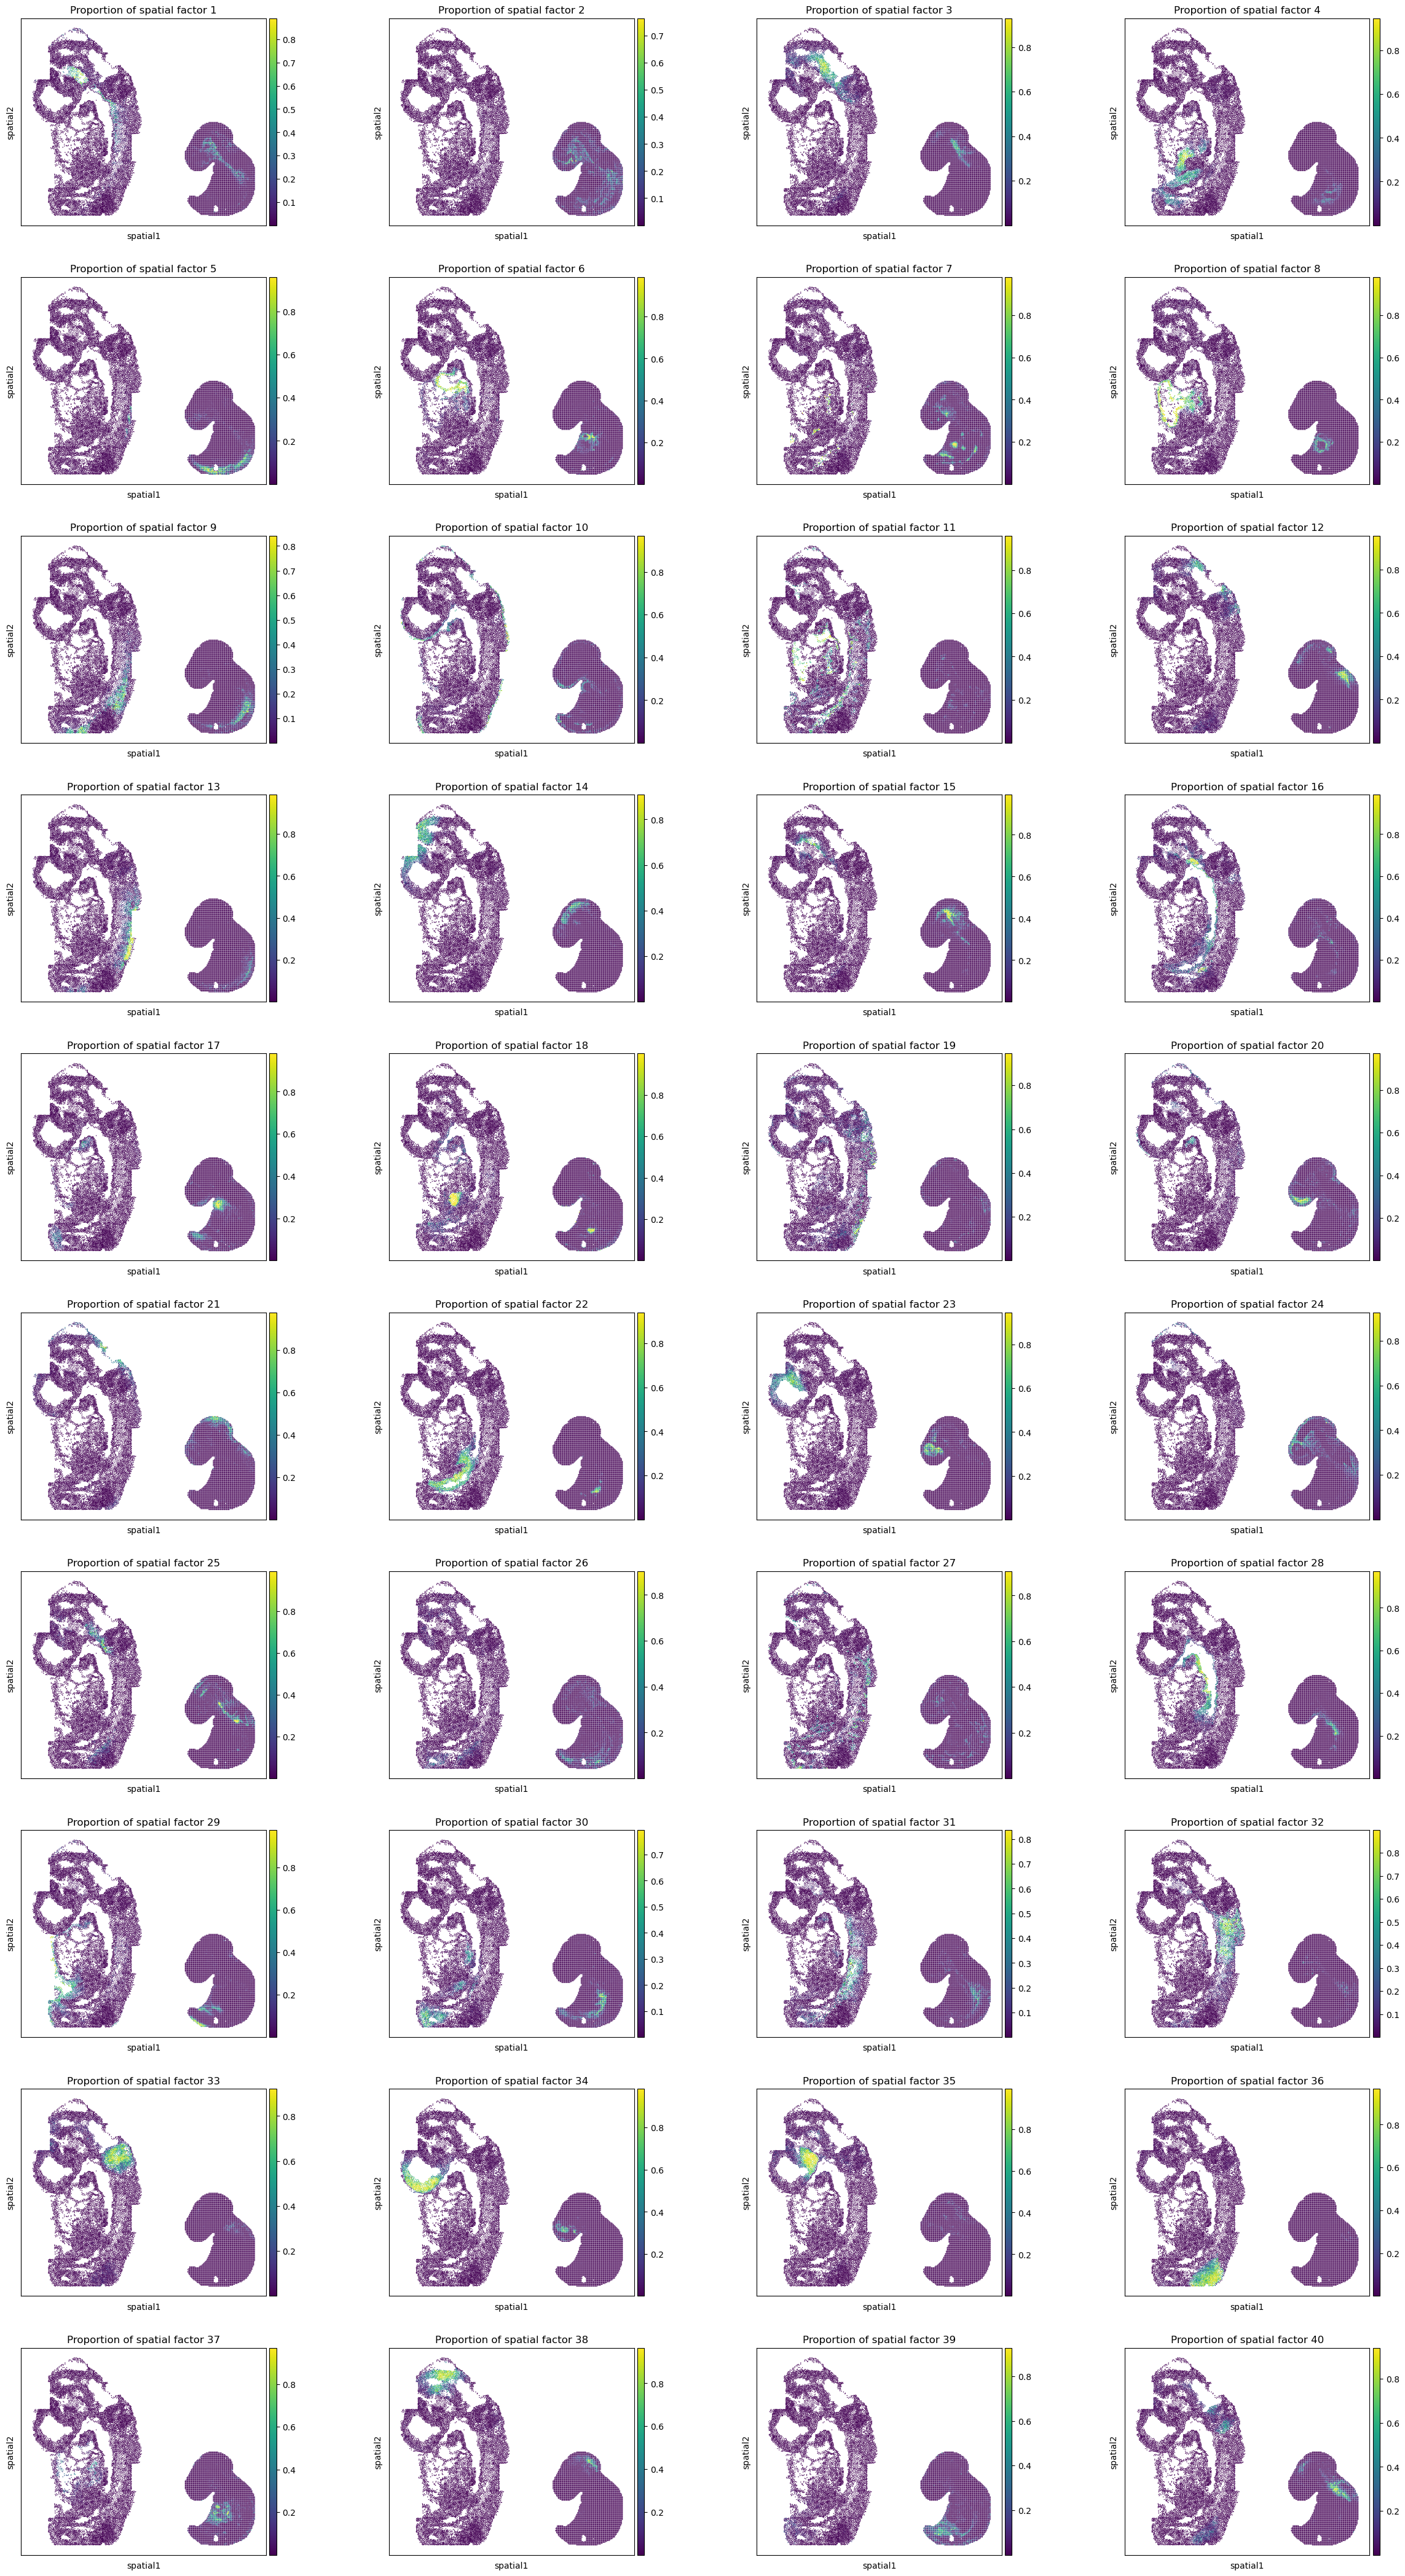

In [11]:
sc.pl.spatial(adata_full, color=["Proportion of spatial factor "+str(i+1) for i in range(40)], spot_size=1.)

### Spot representations and spatial domain identification

Calculate 2D UMAP coordinates of cells based on cell representations.

In [12]:
reducer = umap.UMAP(n_neighbors=30,
                    n_components=2,
                    metric="correlation",
                    n_epochs=None,
                    learning_rate=1.0,
                    min_dist=0.3,
                    spread=1.0,
                    set_op_mix_ratio=1.0,
                    local_connectivity=1,
                    repulsion_strength=1,
                    negative_sample_rate=5,
                    a=None,
                    b=None,
                    random_state=1234,
                    metric_kwds=None,
                    angular_rp_forest=False,
                    verbose=True)
embedding = reducer.fit_transform(adata_full.obsm['latent'])
adata_full.obsm["X_umap"] = embedding
adata_full.obs["slice"] = adata_full.obs["slice"].values.astype(str)

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation', min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1, verbose=True)
Fri Aug 23 16:36:33 2024 Construct fuzzy simplicial set
Fri Aug 23 16:36:33 2024 Finding Nearest Neighbors
Fri Aug 23 16:36:33 2024 Building RP forest with 12 trees
Fri Aug 23 16:36:37 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Aug 23 16:36:45 2024 Finished Nearest Neighbor Search
Fri Aug 23 16:36:47 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Aug 23 16:37:07 2024 Finished embedding


Perform spatial domain identification jointly for the two slices by clustering the integrated cell representations.

In [13]:
sc.pp.neighbors(adata_full, use_rep="latent", n_neighbors=30)
sc.tl.louvain(adata_full, resolution=.7)

Visualization of cell representations.

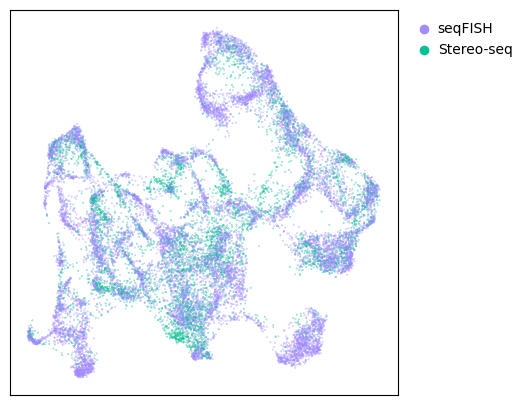

In [14]:
adata = adata_full

size = 0.04
umap = adata.obsm["X_umap"]
n_cells = umap.shape[0]
np.random.seed(1234)
order = np.arange(n_cells)
np.random.shuffle(order)

adata.obs["slice_color"] = ""
adata.obs["slice_color"][adata.obs["slice"].values.astype(str) == str(0)] = "#A58AFF"
adata.obs["slice_color"][adata.obs["slice"].values.astype(str) == str(1)] = "#00C094"

f = plt.figure(figsize=(5,5))

ax3 = f.add_subplot(1,1,1)
scatter2 = ax3.scatter(umap[order, 0], umap[order, 1], s=size, c=adata.obs["slice_color"][order], rasterized=True, marker='o')
ax3.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)

legend_elements_slice = [Line2D([0], [0], marker='o', color="w", label='seqFISH', markerfacecolor="#A58AFF", markersize=10),
                         Line2D([0], [0], marker='o', color="w", label='Stereo-seq', markerfacecolor="#00C094", markersize=10)]
ax3.legend(handles=legend_elements_slice, loc="upper left", bbox_to_anchor=(1, 1), frameon=False, 
           markerscale=.8, fontsize=10, handletextpad=0., ncol=1)

f.subplots_adjust(hspace=0.02, wspace=0.1)
plt.show()

In [15]:
# setup colors
rgb_10 = [i for i in get_cmap('Set3').colors]
rgb_20 = [i for i in get_cmap('tab20').colors]
rgb_20b = [i for i in get_cmap('tab20b').colors]
rgb_dark2 = [i for i in get_cmap('Dark2').colors]
rgb_pst1 = [i for i in get_cmap('Pastel1').colors]
rgb_acc = [i for i in get_cmap('Accent').colors]
rgb2hex_10 = [mpl.colors.rgb2hex(color) for color in rgb_10]
rgb2hex_20 = [mpl.colors.rgb2hex(color) for color in rgb_20]
rgb2hex_20b = [mpl.colors.rgb2hex(color) for color in rgb_20b]
rgb2hex_20b_new = [rgb2hex_20b[i] for i in [0, 3, 4, 7, 8, 11, 12, 15, 16, 19]]
rgb2hex_dark2 = [mpl.colors.rgb2hex(color) for color in rgb_dark2]
rgb2hex_pst1 = [mpl.colors.rgb2hex(color) for color in rgb_pst1]
rgb2hex_acc = [mpl.colors.rgb2hex(color) for color in rgb_acc]
rgb2hex = rgb2hex_20 + rgb2hex_20b_new + rgb2hex_dark2 + rgb2hex_pst1 + rgb2hex_acc
colors = rgb2hex
adata.obs["louvain_color"] = ""
for i in range(len(set(adata.obs["louvain"].values.astype(str)))):
    adata.obs["louvain_color"][adata.obs["louvain"].values.astype(str) == str(i)] = colors[i]

adata.obs["louvain_color"][adata.obs["louvain"].values.astype(str) == str(1)] = rgb2hex[13]
adata.obs["louvain_color"][adata.obs["louvain"].values.astype(str) == str(13)] = rgb2hex[1]

adata.obs["louvain_color"][adata.obs["louvain"].values.astype(str) == str(4)] = rgb2hex[6]
adata.obs["louvain_color"][adata.obs["louvain"].values.astype(str) == str(6)] = rgb2hex[15]
adata.obs["louvain_color"][adata.obs["louvain"].values.astype(str) == str(15)] = rgb2hex[4]

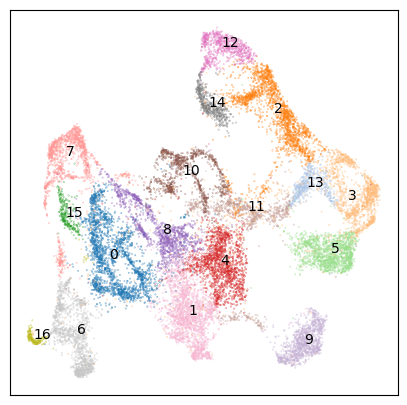

In [16]:
size = 0.04
umap = adata.obsm["X_umap"]
n_cells = umap.shape[0]
np.random.seed(1234)
order = np.arange(n_cells)
np.random.shuffle(order)

f = plt.figure(figsize=(5,5))

ax3 = f.add_subplot(1,1,1)
scatter2 = ax3.scatter(umap[order, 0], umap[order, 1], s=size, c=adata.obs["louvain_color"][order], rasterized=True, marker='o')
ax3.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)

for i in range(len(set(adata.obs["louvain"].values.astype(str)))):
    coor_tmp = umap[adata.obs["louvain"].values.astype(str) == str(i), :]
    coor_xy = np.median(coor_tmp, axis=0)
    ax3.annotate(str(i), coor_xy)

f.subplots_adjust(hspace=0.02, wspace=0.1)
plt.show()

Visualization of spatial region identification result.

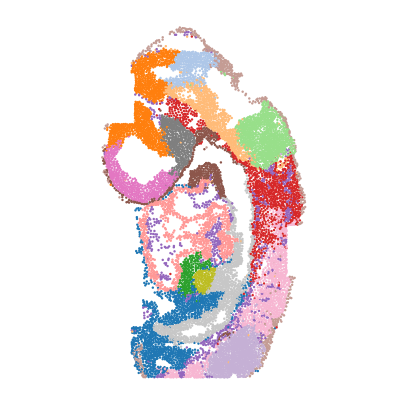

In [17]:
size = 3

# louvain
f = plt.figure(figsize=(5,5))
ax = f.add_subplot(1,1,1)
ax.axis('equal')
colors = rgb2hex
adata_tmp = adata[adata.obs["slice"].values.astype(str) == "0", :]
ax.scatter(adata_tmp.obsm["spatial"][:, 0], 
           -adata_tmp.obsm["spatial"][:, 1], 
           s=size, facecolors=adata_tmp.obs["louvain_color"], edgecolors='none', rasterized=True)
ax.set_axis_off()
f.subplots_adjust(hspace=0.02, wspace=0.1)
plt.show()

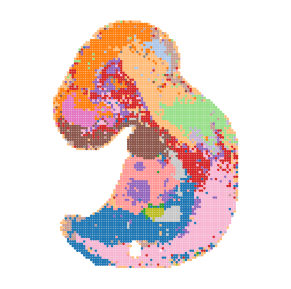

In [18]:
size = 4

# louvain
f = plt.figure(figsize=(3.5,3.5))
ax = f.add_subplot(1,1,1)
ax.axis('equal')
colors = rgb2hex
adata_tmp = adata[adata.obs["slice"].values.astype(str) == "1", :]
ax.scatter(adata_tmp.obsm["spatial"][:, 0], 
           -adata_tmp.obsm["spatial"][:, 1], 
           s=size, facecolors=adata_tmp.obs["louvain_color"], edgecolors='none', rasterized=True)
ax.set_axis_off()
f.subplots_adjust(hspace=0.02, wspace=0.1)
plt.show()

### Save results

In [19]:
### Save results
res_path = "Results/INSPIRE_diff_tech_embryo"
adata_full.write(res_path + "/adata_inspire.h5ad")
basis_df.to_csv(res_path + "/basis_df_inspire.csv")